In [1]:
import os
import sys
home_dir = "../../"
module_path = os.path.abspath(os.path.join(home_dir))
if module_path not in sys.path:
    sys.path.append(module_path)

import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

from data_loader import get_merged_scores_df
from plots_helper import *

In [2]:
method_names = ['random_classifier', 'sift', 'polyphen2_HVAR', 'metarnn', 'revel', 'mvp', 'sequnet', 
           'cadd_raw', 'integrated_fitCons', 'phyloP17way_primate', 'phastCons17way_primate', 'bStatistic', 'conservation',
           'esm1b_t33_650M_UR50S', 'esm1v_t33_650M_UR90S', 'esm2_t33_650M_UR50D', 
           'prottrans_bert_bfd', 'prottrans_t5_xl_u50', 'vespa', 'proteinbert', 'protbert', 'unirep']

In [3]:
df = get_merged_scores_df("popu_freq", home_dir)
df = df[~pd.isna(df["conservation"]) & (df["class"]!="Singleton")]  # taking df for only non-NAN values
df["class"].value_counts()

Index(['snp_id', 'chrom_acc_version', 'chrom_pos', 'ref_allele', 'alt_allele',
       'prot_acc_version', 'prot_pos', 'wt', 'mut', 'wt_population',
       'mut_poulation', 'wt_freq', 'mt_freq', 'class', 'chrom', 'sift',
       'polyphen2_HVAR', 'metarnn', 'revel', 'mvp', 'cadd_raw',
       'integrated_fitCons', 'phyloP17way_primate', 'phastCons17way_primate',
       'bStatistic', 'n_methods_having_preds', 'esm1b_t33_650M_UR50S',
       'esm1v_t33_650M_UR90S', 'esm2_t33_650M_UR50D', 'prottrans_bert_bfd',
       'prottrans_t5_xl_u50', 'vespa', 'proteinbert', 'sequnet', 'protbert',
       'unirep', 'conservation'],
      dtype='object')
(26409, 37)
Common        6976
Ultra-rare    6957
Singleton     6955
Rare          5521
Name: class, dtype: int64


Ultra-rare    3027
Common        2658
Rare          2235
Name: class, dtype: int64

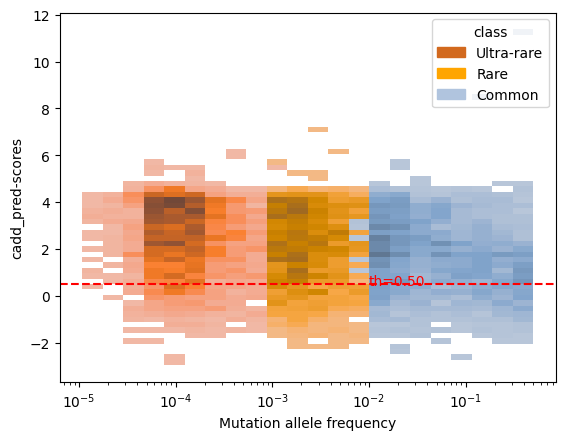

In [4]:
# this is a test for a single method cadd-raw
plt.cla()
ax = sns.histplot(data=df, x="mt_freq", y="cadd_raw", hue="class", log_scale=(True, False), palette=popu_freq_colors_dict, hue_order=popu_freq_class_order_wo_singleton)
plt.axhline(y=.5, color='r', linestyle='dashed')
plt.text(0.01, .5-.05, f"th={.5:.2f}", c="r")
plt.ylabel("cadd_pred-scores")
plt.xlabel("Mutation allele frequency")

plt.show()

	 1.0 1.0
	 1.0 1.0
	 1.0 1.0
	 0.9 0.9902182091798345
	 0.8300000000000001 0.9900358708648864
	 1.0 1.0
	 0.98 0.9928436911487759
	 0.52 0.9932279909706546
	 0.89 0.990226739640344
	 1.0 1.0
	 1.0 1.0
	 1.0 1.0
	 0.77 0.9909706546275395
	 0.8 0.9909706546275395
	 0.78 0.9932279909706546
	 0.75 0.9902182091798345
	 0.81 0.9902182091798345
	 0.81 0.9902182091798345
	 0.15 0.990594431903687
	 0.27 0.9917231000752446
	 0.28 0.9902182091798345


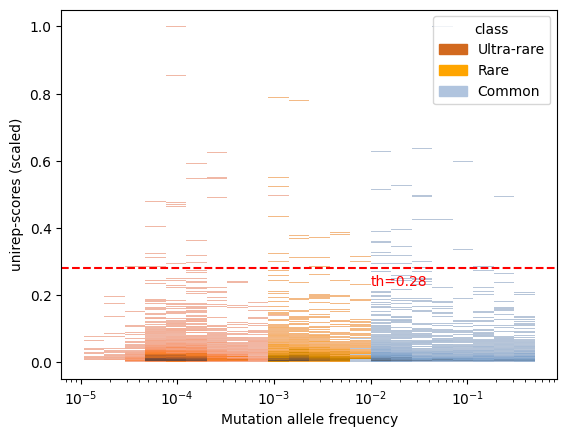

In [5]:
def do_hist_plot(df, method_name):
    ax = sns.histplot(data=df, x="mt_freq", y="pred", hue="class", log_scale=(True, False), palette=popu_freq_colors_dict, hue_order=popu_freq_class_order_wo_singleton)
    plt.xlabel("Mutation allele frequency")
    plt.ylabel(f"{method_name}-scores (scaled)")


def find_and_plot_th(df): # finding a th such that >99% of the common variants are correctly classified
    df.loc[df["class"]=="Common", "class_numeric"] = 1
    df.loc[df["class"]!="Common", "class_numeric"] = 0

    best_th = 0.0
    for th in np.arange(0, 1.1, .01):
        df.loc[df["pred"]<=th, "class_numeric_assigned"] = 1
        df.loc[df["pred"]>th, "class_numeric_assigned"] = 0

        temp_df = df[df["class"]=="Common"].copy()
        n_rows_annotated_as_common = temp_df[temp_df["class_numeric"]==temp_df["class_numeric_assigned"]]
        percentage = n_rows_annotated_as_common.shape[0]/temp_df.shape[0]
        if percentage >= .99:
            print("\t", th, percentage)
            best_th = th
            break
    plt.axhline(y=best_th, color='r', linestyle='dashed')
    plt.text(0.01, best_th-.05, f"th={best_th:.2f}", c="r")


for i, method_name in enumerate(method_names):
    plt.cla()
    # method_name = "esm1b_t33_650M_UR50S"
    if method_name=="conservation": continue
    if method_name=="random_classifier": df[method_name] = [random.uniform(0, 1) for i in range(df.shape[0])]
    
    non_nan_df = df[~pd.isna(df[method_name])].copy()  # taking df for only non-NAN values
    non_nan_df["pred"]=(non_nan_df[method_name]-non_nan_df[method_name].min())/(non_nan_df[method_name].max()-non_nan_df[method_name].min()) # scaling prediction scores between [0, 1]
    
    find_and_plot_th(non_nan_df)
    do_hist_plot(non_nan_df, method_name)
    
    # plt.show()
    plt.savefig(home_dir+f"models/aa_common/plots_mut_allele_freq_vs_scores_histogram/{method_name}.png", dpi=300, format="png", bbox_inches='tight', pad_inches=0.0)
    # break